# Detect overlapping between sources in cosmoDC2 and the object catalog

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Ellipse
from astropy.table import Table, join

import desc_dc2_dm_data

import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display.rgb as rgb
import pandas as pd

from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval

# define the object and the truth catalogs

In [2]:
from GCR import GCRQuery
from GCRCatalogs.dc2_truth_match import _flux_to_mag as flux_to_mag
import GCRCatalogs
import fitsio

In [3]:
#test.list_all_quantities()

### get all objects in tract 3447; no cuts at all

In [4]:
if 0:
    
    object_cat = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons')
   
    ## filters for the object catalog
    '''
    cuts = [
        GCRQuery((np.isfinite, 'mag_i')), # Select objects that have i-band magnitudes
        GCRQuery('clean'),            # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                                      # and was not skipped by the deblender
        GCRQuery('mag_i_cModel < 24.5')  # cModel imag brighter than 24.5
    ]
    '''
    
    # Load ra and dec from object, using both of the filters we just defined.
    object_data = object_cat.get_quantities(['ra', 'dec', 'x', 'y', 'extendedness', \
                                             'Ixx_pixel', 'Iyy_pixel', 'Ixy_pixel', \
                                          'mag_i_cModel', 'mag_r_cModel', \
                                         'photoz_mode', 'blendedness', 'tract', 'patch', 'clean'],
                                            native_filters=['tract == 3828'])
                                        #filters=cuts, native_filters=['tract == 3447'])
    
    obj_all = pd.DataFrame(object_data)
    obj_all['obj_id'] = [i for i in range(len(obj_all))]
    obj_all.to_pickle('obj_tract_3447.pkl')
    
else:
    
    obj_all = pd.read_pickle('obj_tract_3447.pkl')
    obj_all = Table.from_pandas(obj_all)

### Only use objects from the Patches covered by truth catalog

In [5]:
# tract 3447
mask = np.zeros(len(obj_all), dtype=bool)

for i in ['0', '1', '2', '3', '4']:
    pat = f'0,{i}'              
    mask = mask | (obj_all['patch'] == pat)
    
for i in ['0', '1', '2', '3']:
    pat = f'1,{i}'              
    mask = mask | (obj_all['patch'] == pat)
    
for i in ['0', '1', '2']:
    pat = f'2,{i}'              
    mask = mask | (obj_all['patch'] == pat)

mask = mask | (obj_all['patch'] == '3,0')

obj = obj_all[mask]


In [6]:
if 0:
    
    truth_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
    stars_cat = GCRCatalogs.load_catalog("dc2_truth_run2.2i_star_truth_summary")
    
    #stars_cat.list_all_quantities()
    
    if not stars_cat.has_quantity("mag_i"):
        stars_cat.add_derived_quantity("mag_i", flux_to_mag, "flux_i")
    
    if not stars_cat.has_quantity("mag_r"):
        stars_cat.add_derived_quantity("mag_r", flux_to_mag, "flux_r")

    min_ra = obj['ra'].min()
    max_ra = obj['ra'].max()
    min_dec = obj['dec'].min()
    max_dec = obj['dec'].max()

    pos_filters = [f'ra >= {min_ra}',f'ra <={max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']
    

    filters = pos_filters  + ['mag_i < 28' ]

    truth_gals = truth_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'mag_i', 'mag_r', 'redshift',\
                                           'size_true', 'size_minor_true', 'position_angle_true',
                                           'halo_id', 'halo_mass', 'is_central'], filters=filters)
    truth_gals = pd.DataFrame(truth_gals)
    
    truth_gals["star"] = False
    truth_gals = truth_gals.rename(columns={"galaxy_id": "id"})
    
    
    
    truth_stars = stars_cat.get_quantities(['id', 'ra', 'dec', 'mag_i', 'mag_r', 'redshift'], filters=filters)
    truth_stars = pd.DataFrame(truth_stars)
    
    for col in ['size_true', 'size_minor_true', 'position_angle_true','halo_id', 'halo_mass', 'is_central']:
        truth_stars[col] = 0
    
    truth_stars["star"] = True
    truth_stars["id"] = truth_stars["id"].astype(np.int64)

    truth = pd.concat([truth_gals, truth_stars], ignore_index=True)
    
    truth.to_pickle('truth_tract_3447.pkl')
    
else:
    
    truth = pd.read_pickle('truth_tract_3447.pkl')
    truth = Table.from_pandas(truth)

## Footprint of the example source catalog; 

963723
283447


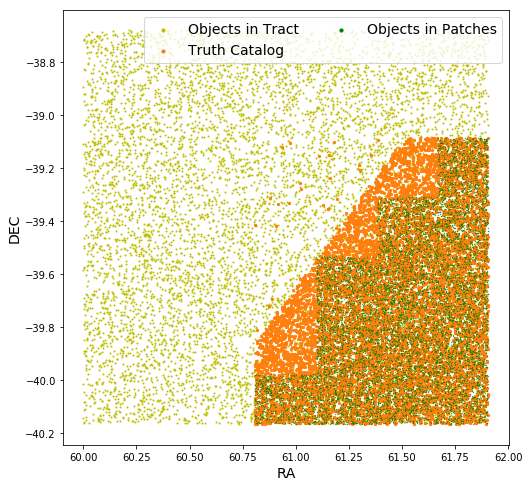

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

rand_ind = np.random.randint(len(obj_all), size=10000)
ax.scatter(obj_all['ra'][rand_ind], obj_all['dec'][rand_ind], c='y', s=1, label='')

rand_ind = np.random.randint(len(truth), size=10000)
ax.scatter(truth['ra'][rand_ind], truth['dec'][rand_ind], c='C1', s=5, label='')

rand_ind = np.random.randint(len(obj), size=10000)
ax.scatter(obj['ra'][rand_ind], obj['dec'][rand_ind], c='g', s=0.1, label='')

ax.scatter([], [], c='y', s=10, label='Objects in Tract')
ax.scatter([], [], c='C1', s=10, label='Truth Catalog')
ax.scatter([], [], c='g', s=10, label='Objects in Patches')

ax.set_xlabel('RA', fontsize=14)
ax.set_ylabel('DEC', fontsize=14)
ax.legend(prop={'size':14}, ncol=2)

print(len(truth))
print(len(obj))

# The Ellipse Equation: 
## (https://en.wikipedia.org/wiki/Ellipse#General_ellipse , but swapping B and C)

$$
A x^2 + B y^2 + C x y +  D x +  E y + F = 0
$$
where 

$$
\begin{align}
A & = a^2\sin^2{\theta} +  b^2\cos^2{\theta},  \\
B & = a^2\cos^2{\theta} +  b^2\sin^2{\theta}, \\
C & = 2(b^2 - a^2)\sin{\theta}\cos{\theta}, \\
D & = -2Ax_0 - Cy_0,  \\
E & = -C x_0 - 2B y_0,  \\
F & = Ax_0^2 + C x_0 y_0 + By_0^2 - a^2 b^2. 
\end{align}
$$

$x_0, y_0$ are the coordinates for the ellipse center, $a$, $b$ the semi-major/minor axis and $\theta$ the position angle (the angle between the major axis and ra for the extragalactic catalog, and between the major axis and CCD x axis for the object catalog).

### following the definitions of https://www.sciencedirect.com/science/article/abs/pii/S0167839617300791 (hereafter AC2017):  
shrink the parameters CDE by half,

$$ C = C / 2, \quad D = D / 2, \quad E = E / 2, $$

and modify the Ellipse Equation:

$$
A x^2 + B y^2 + 2C x y + 2 D x + 2 E y + F = 0.
$$




In [8]:
def ellipse_equation(x, y, params):
    
    A, B, C, D, E, F = params
    
    return A*x**2 + B*y**2 + 2*C*x*y + 2*D*x + 2*E*y + F

def ab2AB(a, b, theta, x0, y0):
    
    ### a, b, in any length units; theta in degrees ###
    sin = np.sin(np.radians(theta))
    cos = np.cos(np.radians(theta))
    
    A = (a*sin)**2 + (b*cos)**2
    B = (a*cos)**2 + (b*sin)**2
    C = 2*(b**2 - a**2)*sin*cos
    D = -2*A*x0 - C*y0
    E = -C*x0 - 2*B*y0
    F = A*x0**2 + C*x0*y0 + B*y0**2 - (a*b)**2
    C, D, E = C/2, D/2, E/2
    
    return [A, B, C, D, E, F]

## The function is_overlapping provides a linear algorithm to detect overlapping ellipses, following AC2017.

In [9]:
def is_overlapping(p1, p2):
    
    A1, B1, C1, D1, E1, F1 = p1
    A2, B2, C2, D2, E2, F2 = p2
        
    M1 = [[A1, C1, D1], [C1, B1, E1], [D1, E1, F1]]
    M2 = [[A2, C2, D2], [C2, B2, E2], [D2, E2, F2]]
    
    l0 = np.linalg.det(M2)
    l1 = (np.linalg.det([[A1,C2,D2],[C1,B2,E2],[D1,E2,F2]]) +
            np.linalg.det([[A2,C1,D2],[C2,B1,E2],[D2,E1,F2]]) +
            np.linalg.det([[A2,C2,D1],[C2,B2,E1],[D2,E2,F1]])) / 3
    l2 = (np.linalg.det([[A2,C1,D1],[C2,B1,E1],[D2,E1,F1]]) +
            np.linalg.det([[A1,C2,D1],[C1,B2,E1],[D1,E2,F1]]) +
            np.linalg.det([[A1,C1,D2],[C1,B1,E2],[D1,E1,F2]])) / 3
    l3 = np.linalg.det(M1)

    delta1 = np.linalg.det([[l3, l2],[l2, l1]])
    delta2 = np.linalg.det([[l3, l1],[l2, l0]])
    delta3 = np.linalg.det([[l2, l1],[l1, l0]])
    discriminant_P = np.linalg.det([[2*delta1, delta2], [delta2, 2*delta3]])
    
    if (discriminant_P >=0) and ((l1>0) or (l2>0)):
        return False  ## not over-lapping
    else:
        return True

# To get the Ellipse parameters ABCDEF from the Object Catalog (deprecated):
based on my calculation, for perfect ellipses with **top-hat constant-disk flux distribution:**
$$ 
\begin{align}
I_{xx} & = \frac{\pi}{4}ab \left( a^2\cos^2{\theta} + b^2\sin^2{\theta} \right), \\
I_{yy} & = \frac{\pi}{4}ab \left( a^2\sin^2{\theta} + b^2\cos^2{\theta} \right), \\ 
I_{xy} & = \frac{\pi}{4}ab \left( a^2 - b^2 \right) \cos{\theta}\sin{\theta}.
\end{align}
$$
therefore,
$$ 
\begin{align}
I_{xx}I_{yy} - I^2_{xy} 
    & = \frac{\pi^2}{16}a^2 b^2 
    \left[ \left( a^2\cos^2{\theta} + b^2\sin^2{\theta} \right) 
    \left( a^2\sin^2{\theta} + b^2\cos^2{\theta} \right) -
    \left( a^2 - b^2 \right)^2 \cos^2{\theta}\sin^2{\theta} \right] \\
    & = \frac{\pi^2}{16}a^4 b^4
\end{align}
$$
or

$$ \pi ab = 2\sqrt{\pi} \left( I_{xx}I_{yy} - I^2_{xy} \right)^{1/4}. $$

Furthermore, 

$$
\begin{align}
A & = a^2\sin^2{\theta} +  b^2\cos^2{\theta} = \frac{4I_{yy}}{\pi ab},  \\
B & = a^2\cos^2{\theta} +  b^2\sin^2{\theta} = \frac{4I_{xx}}{\pi ab}, \\
C & = 2(b^2 - a^2)\sin{\theta}\cos{\theta} = \frac{-8I_{xy}}{\pi ab}, \\ 
\end{align}
$$

and D, E, F follows.


Alternatively, calculate a, b, $\theta$ from the second moments first:
$$
\begin{align}
       \tan{2\theta} & = \frac{2 I_{xy}}{I_{xx} - I_{yy}}, \\
       a^2 & = \frac{4(I_{xx}\cos^2{\theta} - I_{yy}\sin^2{\theta})}{\pi ab \cos{2\theta}}, \\
       b^2 & = \frac{4(I_{yy}\cos^2{\theta} - I_{xx}\sin^2{\theta})}{\pi ab \cos{2\theta}}.
\end{align}
$$

In [10]:
def moments2AB_tophat(Ixx, Iyy, Ixy, x0, y0):
    
    ### Ixx, Iyy, Ixy in same unit as (x0, y0) ###
   
    pi_ab = 2 * np.sqrt(np.pi) * np.power(Ixx*Iyy - Ixy**2, 1/4)

    A = 4*Iyy/pi_ab
    B = 4*Ixx/pi_ab
    C = -8*Ixy/pi_ab

    D = -2*A*x0 - C*y0
    E = -C*x0 - 2*B*y0

    F = A*x0**2 + C*x0*y0 + B*y0**2 - (pi_ab/np.pi)**2
    C, D, E = C/2, D/2, E/2
    
    return [A, B, C, D, E, F]


def moments2ab_tophat(Ixx, Iyy, Ixy):
    
    ### Ixx, Iyy, Ixy in same unit as (x0, y0) ###
   
    pi_ab = 2 * np.sqrt(np.pi) * np.power(Ixx*Iyy - Ixy**2, 1/4)
    
    theta2 = np.arctan2(2*Ixy, Ixx-Iyy)
    theta2[theta2<0] += 2*np.pi
    
    theta = theta2 / 2
    
    sin = np.sin(theta)
    cos = np.cos(theta)
    cos2t = cos**2 - sin**2
    
    a_square = 4*(Ixx*cos**2 - Iyy*sin**2) / (pi_ab * cos2t)
    b_square = 4*(Iyy*cos**2 - Ixx*sin**2) / (pi_ab * cos2t)
    
    return [np.sqrt(a_square), np.sqrt(b_square), np.degrees(theta)]


# To get the Ellipse parameters ABCDEF from the Object Catalog (Current Version)

## Define a 2D elliptical Gaussian (centered at origin) as:

$$
G(\textbf{r}) = \frac{F}{2\pi\sqrt{|\Sigma|}}\exp\left(-\frac{\textbf{r}\cdot\Sigma^{-1}\cdot\textbf{r}}{2}\right)
$$
where
$$
\begin{equation}
    \Sigma = \begin{bmatrix} I_{xx} &  I_{xy}\\ I_{xy} & I_{yy} \end{bmatrix}
\end{equation}  
$$
and
\begin{equation}
    \Sigma^{-1} = \frac{1}{I_{xx}I_{yy} -  I_{xy}^2}\begin{bmatrix} I_{yy} &  -I_{xy}\\ -I_{xy} & I_{xx} \end{bmatrix}.
\end{equation}

Some calculation leads to:
$$
\begin{align}
    I_{xx} &= \frac{1}{2\ln{2}} \left( a^2 \cos^2 \theta + b^2 \sin^2 \theta \right) \\
    I_{xy} &= \frac{1}{2\ln{2}} \left( a^2 - b^2 \right) \sin \theta \cos \theta  \\
    I_{yy} &= \frac{1}{2\ln{2}} \left( a^2 \sin^2 \theta + b^2 \cos^2 \theta  \right),
\end{align}
$$
where $a, b, \theta$ is defined by the FWHM contour. Then,
$$
\begin{align}
I_{xx}I_{yy} - I^2_{xy} 
    & = \frac{1}{4(\ln{2})^2} 
    \left[ \left( a^2\cos^2{\theta} + b^2\sin^2{\theta} \right) 
    \left( a^2\sin^2{\theta} + b^2\cos^2{\theta} \right) -
    \left( a^2 - b^2 \right)^2 \cos^2{\theta}\sin^2{\theta} \right] \\
    & = \frac{a^2 b^2}{4(\ln{2})^2}, \\
\Sigma & = \frac{1}{2 \ln{2}}\begin{bmatrix} a^2 \cos^2 \theta + b^2 \sin^2 \theta &  (a^2 - b^2) \sin \theta \cos \theta \\
    (a^2 - b^2) \sin \theta \cos \theta & a^2 \sin^2 \theta + b^2 \cos^2 \theta \end{bmatrix}, \\
\Sigma^{-1} & = \frac{2\ln{2}}{a^2 b^2}\begin{bmatrix} a^2 \sin^2 \theta + b^2 \cos^2 \theta &  (b^2 - a^2) \sin \theta \cos \theta \\
    (b^2 - a^2) \sin \theta \cos \theta & a^2 \cos^2 \theta + b^2 \sin^2 \theta \end{bmatrix}.
\end{align}
$$

## Converting the moments to ellipse parameters:
$$
\begin{align}
       \tan{2\theta} & = \frac{2 I_{xy}}{I_{xx} - I_{yy}}, \\
       a^2 & = \frac{2 \ln{2}(I_{xx}\cos^2{\theta} - I_{yy}\sin^2{\theta})}{\cos{2\theta}}, \\
       b^2 & = \frac{2 \ln{2}(I_{yy}\cos^2{\theta} - I_{xx}\sin^2{\theta})}{\pi ab \cos{2\theta}}.
\end{align}
$$

In [11]:
def moments2ab(Ixx, Iyy, Ixy):
    
    ### Ixx, Iyy, Ixy in same unit as (x0, y0) ###
   
    theta2 = np.arctan2(2*Ixy, Ixx-Iyy)
    theta2[theta2<0] += 2*np.pi
    
    theta = theta2 / 2
    
    sin = np.sin(theta)
    cos = np.cos(theta)
    cos2t = cos**2 - sin**2
    
    a_square = 2*np.log(2)*(Ixx*cos**2 - Iyy*sin**2) / cos2t
    b_square = 2*np.log(2)*(Iyy*cos**2 - Ixx*sin**2) / cos2t
    
    return [np.sqrt(a_square), np.sqrt(b_square), np.degrees(theta)]


#### verify the pixel scale (it's 0.2''/pix from https://arxiv.org/pdf/2010.05926.pdf)

In [12]:
N = len(obj)
i = np.random.randint(0, high=N)
j = np.random.randint(0, high=N)
print('pixel scale caculated from pair sources:', (i, j))

x1, y1 = obj['x'][i], obj['y'][i]
x2, y2 = obj['x'][j], obj['y'][j]
dist_pixel = np.sqrt( (x1-x2)**2 + (y1-y2)**2 )

ra1, dec1 = np.radians(obj['ra'][i]), np.radians(obj['dec'][i])
ra2, dec2 = np.radians(obj['ra'][j]), np.radians(obj['dec'][j])

cos_dist = np.sin(dec1)*np.sin(dec2) + np.cos(dec1)*np.cos(dec2)*np.cos(ra1-ra2)
dist_rad = np.arccos(cos_dist)
dist_arcsec = np.degrees(dist_rad)*3600

pixel_ratio = dist_arcsec / dist_pixel
print('pixel scale:', pixel_ratio, 'arcsec/pix')

pixel scale caculated from pair sources: (53812, 86967)
pixel scale: 0.1999887113612651 arcsec/pix


## calculate ellipse parameters for each object; everything in pixel coordinates

In [13]:
x0 = obj['x']
y0 = obj['y']

Ixx = obj['Ixx_pixel']
Iyy = obj['Iyy_pixel']
Ixy = obj['Ixy_pixel']

obj['a_obj'], obj['b_obj'], obj['theta_obj'] = moments2ab(Ixx, Iyy, Ixy)
obj['a_obj_tophat'], obj['b_obj_tophat'], obj['theta_obj_tophat'] = moments2ab_tophat(Ixx, Iyy, Ixy)


/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [14]:
am = np.mean(obj['a_obj_tophat'])

In [15]:
bm = np.mean(obj['b_obj_tophat'])

In [16]:
## equivalent fudge factor comparing to top-hat profile
np.sqrt(2*np.log(2) / (4/(np.pi * am * bm)))

1.6469090007357476

## Plot detected shape of some sources

In [17]:
def plot_shape(x0, y0, rough_size, params, c='b', ls='-', ax=None):
    
    x = np.linspace(x0 - rough_size, x0 + rough_size, 100)
    y = np.linspace(y0 - rough_size, y0 + rough_size, 100)
    x, y = np.meshgrid(x,y)
 
    z = ellipse_equation(x, y, params)
    
    ax.contour(x, y, z, [0], colors=c, linestyles=ls) 

In [18]:
pat = '2,2'
obj_patch = obj[ obj['patch'] == pat ]

N = len(obj_patch)

x0 = obj_patch['x']
y0 = obj_patch['y']

a = obj_patch['a_obj']
b = obj_patch['b_obj']
theta = obj_patch['theta_obj']

a_tp = obj_patch['a_obj_tophat']
b_tp = obj_patch['b_obj_tophat']
theta_tp = obj_patch['theta_obj_tophat']


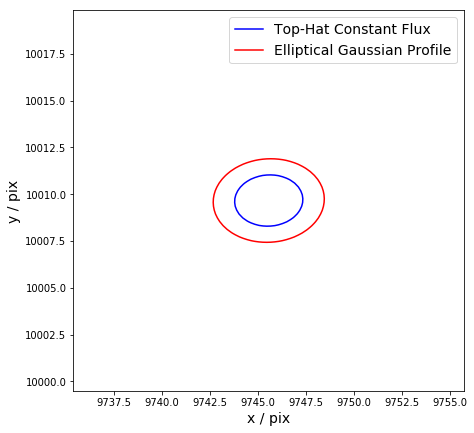

In [19]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

for i in np.random.randint(0, high=N, size=1):
    
    rough_size = 4*np.sqrt( a[i]*b[i] )
    
    params = ab2AB(a_tp[i], b_tp[i], theta_tp[i], x0[i], y0[i])
    plot_shape( x0[i], y0[i], rough_size, params, c='b', ls='-', ax=ax)
    
    params = ab2AB(a[i], b[i], theta[i], x0[i], y0[i])
    plot_shape( x0[i], y0[i], rough_size, params, c='r', ls='-', ax=ax)

    ax.set_xlabel('x / pix', fontsize=14)
    ax.set_ylabel('y / pix', fontsize=14)

    ax.plot([], [], 'b', label='Top-Hat Constant Flux')
    ax.plot([], [], 'r', label='Elliptical Gaussian Profile')
    
    ax.legend(prop={'size':14})

# Overlay on Images

In [20]:
sorted(desc_dc2_dm_data.REPOS)

['1.1p',
 '1.2i',
 '1.2p',
 '1.2p_v3',
 '1.2p_v4',
 '2.1i',
 '2.1i_dr1a',
 '2.1i_dr1b',
 '2.1i_dr4',
 '2.1i_v1',
 '2.2i_dia_y2_t3828',
 '2.2i_dr2',
 '2.2i_dr2_tract3828',
 '2.2i_dr2_wfd',
 '2.2i_dr3',
 '2.2i_dr6',
 '2.2i_dr6_v1',
 '2.2i_dr6_wfd',
 'dia_2020Jan']

## Find tract and patch for objects

In [21]:
dc2_data_version = "2.2i_dr6_wfd"
butler = desc_dc2_dm_data.get_butler(dc2_data_version)

skymap = butler.get('deepCoadd_skyMap')

object_this = obj_patch[0]
dataId = {"tract": object_this["tract"], "patch": object_this["patch"], "filter": "i"}

In [22]:
full_patch = butler.get("deepCoadd", dataId=dataId)

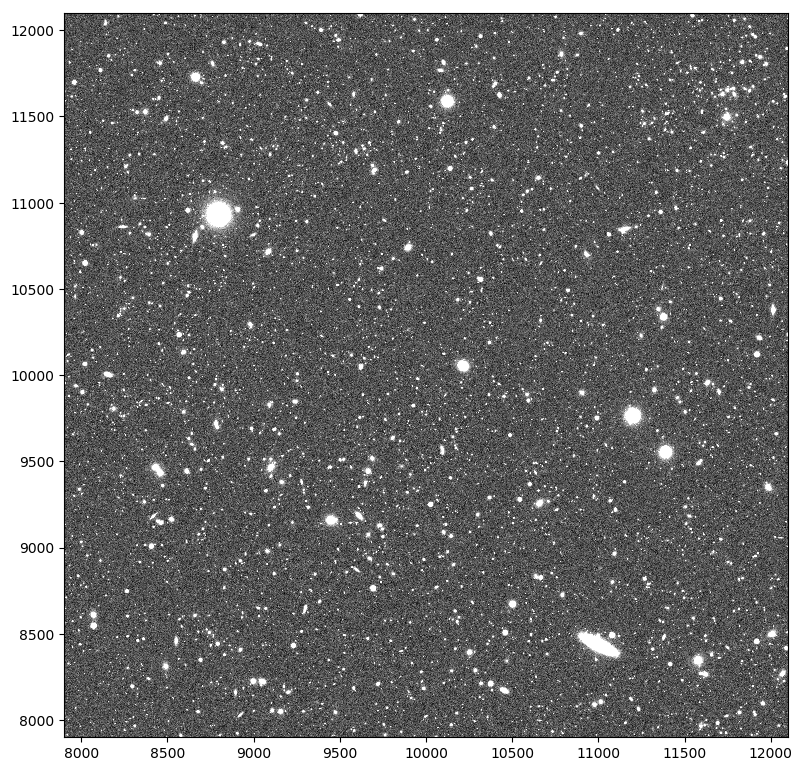

In [23]:
fig = plt.figure(figsize=(8, 8), dpi=100)
# Note that we set frame=1 below to allow afwDisplay to use the figure instance we created
display = afwDisplay.Display(1, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(full_patch.getMaskedImage().getImage())


## only looking at bright sources

In [24]:
pat = '2,2'
obj_patch = obj[ (obj['patch'] == pat) & (obj['mag_i_cModel']<24.5) ]

N = len(obj_patch)

x0 = obj_patch['x']
y0 = obj_patch['y']

a = obj_patch['a_obj']
b = obj_patch['b_obj']
theta = obj_patch['theta_obj']

a_tp = obj_patch['a_obj_tophat']
b_tp = obj_patch['b_obj_tophat']
theta_tp = obj_patch['theta_obj_tophat']


/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


4598 23.3333357032852


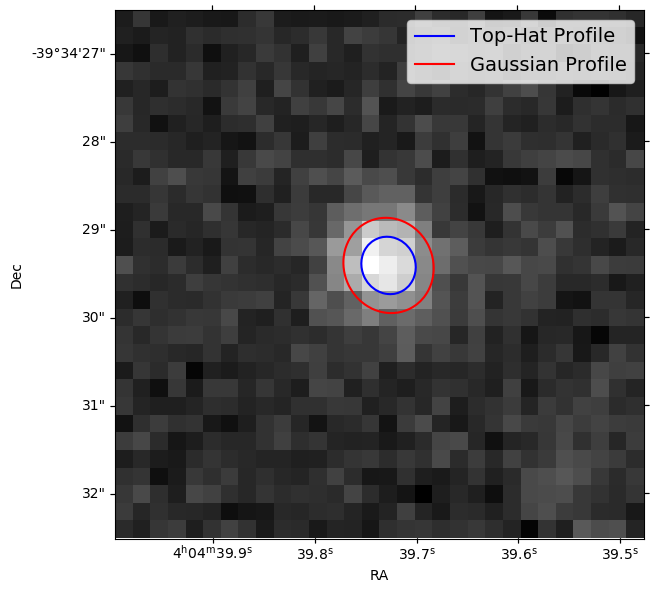

In [25]:

cutout_size = 30  # 300 pixels -> about 1 arcmin; use even-number size!!
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

for i in np.random.randint(0, high=N, size=1):
#for i in [2061, 558, 1294, 1476, 1845, 1858, 1875, 1881, 2008, 505, 558]:
#for i in [345]:
    
    print(i, obj_patch['mag_i_cModel'][i])
    radec = lsst.geom.SpherePoint(obj_patch["ra"][i], obj_patch["dec"][i], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    
    if np.floor(center.x) - np.round(center.x) == 0:
        pix_center_x = center.x
    else:
        pix_center_x = center.x + 1
        
    if np.floor(center.y) - np.round(center.y) == 0:
        pix_center_y = center.y
    else:
        pix_center_y = center.y + 1
    
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((pix_center_x - cutout_size*0.5, pix_center_y - cutout_size*0.5)), cutout_extent)

    cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)
    wcs = cutout.getWcs()

    off = lsst.geom.Extent2D(-(pix_center_x - cutout_size*0.5), -(pix_center_y - cutout_size*0.5))
    wcs_new = wcs.copyAtShiftedPixelOrigin(off)
    wcs_fits_meta = wcs_new.getFitsMetadata()
    
    image_arr = cutout.getMaskedImage().getImage().array
    #center_new = wcs_new.skyToPixel(radec)
    
    fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(7, 7), dpi=100)

    #vmin, vmax = ZScaleInterval().get_limits(image_arr)
    vmin, vmax = image_arr.min(), image_arr.max()
    
    ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')
    
    rough_size = 4*np.sqrt( a[i]*b[i] )
    
    params = ab2AB(a_tp[i], b_tp[i], theta_tp[i], cutout_size/2, cutout_size/2)
    plot_shape( cutout_size/2, cutout_size/2, rough_size, params, c='b', ls='-', ax=ax)
    
    params = ab2AB(a[i], b[i], theta[i], cutout_size/2, cutout_size/2)
    plot_shape( cutout_size/2, cutout_size/2, rough_size, params, c='r', ls='-', ax=ax)
    
    ax.plot([], [], 'b', label='Top-Hat Profile')
    ax.plot([], [], 'r', label='Gaussian Profile')

    
    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    
    ax.legend(prop={'size':14})
    
    #plt.savefig(f'./obj/{i}.jpeg')
    #plt.cla()

# measure the PSF by looking at stars 
### (to convolve with the sizes of truth catalog). Comparing two kinds of sizes:

### 1. stars of top-hat constant flux within radius $r$, 

$$I_{xx} = I_{yy} = \frac{\pi}{4}r^4, \quad I_{xy} = 0,$$ 

and

$$ r = \left( \frac{2(I_{xx} + I_{yy})}{\pi} \right)^{1/4}. $$

### 2. stars of 2d Gaussian profile with FWHM contour defined by $a=b=r$,
$$I_{xx} = I_{yy} = \frac{r^2}{2\ln{2}}, \quad I_{xy} = 0, $$

or

$$
r = \sqrt{ \ln{2}\left(I_{xx} + I_{yy}\right)}
$$

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


PSF size: 0.4173324946862651 [arcsecs]


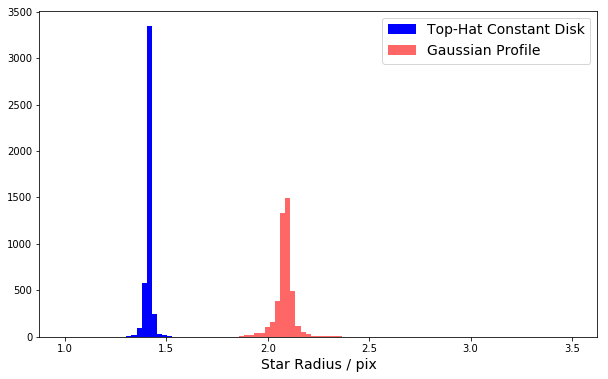

In [26]:
stars = obj[ (obj['extendedness'] == 0 ) & (obj['clean']) & (obj['mag_i_cModel']<24.5)]

Ixx = stars['Ixx_pixel'] ## in pixels
Iyy = stars['Iyy_pixel'] ## in pixels

stars['r_tp'] = np.power(2*(Ixx + Iyy)/np.pi, 1/4)
stars['r_gauss'] = np.sqrt(np.log(2) * (Ixx+Iyy))


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.hist(stars['r_tp'], bins=np.linspace(1,3.5,100), color='b', label='Top-Hat Constant Disk')
ax.hist(stars['r_gauss'], bins=np.linspace(1,3.5,100), color='r', alpha=0.6, label='Gaussian Profile')

ax.set_xlabel('Star Radius / pix', fontsize=14)
ax.legend(prop={'size':14})

psf = np.median(stars['r_gauss']) * 0.2 / 3600    ## in degree; pixel ratio is 0.2"/pix
print('PSF size:', psf*3600, '[arcsecs]')         ## isn't this too small?

In [27]:
stars = stars[ stars['patch'] == pat ]

128


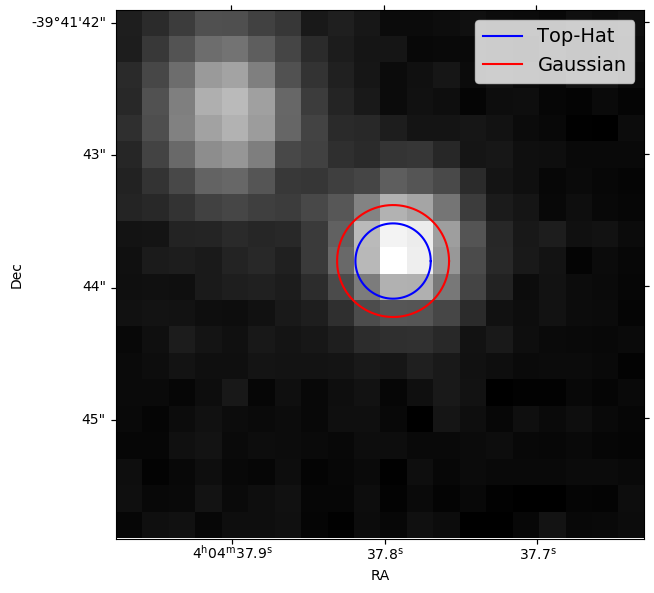

In [28]:

cutout_size = 20  # 300 pixels -> about 1 arcmin; use even-number size!!
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

theta = np.linspace(0, 2*np.pi, 100)
x = np.cos(theta)
y = np.sin(theta)

N = len(stars)
for i in np.random.randint(0, high=N, size=1):

    print(i)

    radec = lsst.geom.SpherePoint(stars["ra"][i], stars["dec"][i], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    
    if np.floor(center.x) - np.round(center.x) == 0:
        pix_center_x = center.x
    else:
        pix_center_x = center.x + 1
        
    if np.floor(center.y) - np.round(center.y) == 0:
        pix_center_y = center.y
    else:
        pix_center_y = center.y + 1
    
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((pix_center_x - cutout_size*0.5, pix_center_y - cutout_size*0.5)), cutout_extent)
    
    cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)
    wcs = cutout.getWcs()

    #off = lsst.geom.Extent2D(-(center.x - cutout_size*0.5), -(center.y - cutout_size*0.5))
    off = lsst.geom.Extent2D(-(pix_center_x - cutout_size*0.5), -(pix_center_y - cutout_size*0.5))
    wcs_new = wcs.copyAtShiftedPixelOrigin(off)
    #center_new = wcs_new.skyToPixel(radec)
    
    wcs_fits_meta = wcs_new.getFitsMetadata()
    image_arr = cutout.getMaskedImage().getImage().array
    
    fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(7, 7), dpi=100)

    
    #vmin, vmax = ZScaleInterval().get_limits(image_arr)
    vmin, vmax = image_arr.min(), image_arr.max()
    ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')
    
    ax.plot(cutout_size/2 + stars['r_tp'][i]*x, cutout_size/2 + stars['r_tp'][i]*y, 'b', label='Top-Hat')
    ax.plot(cutout_size/2 + stars['r_gauss'][i]*x, cutout_size/2 + stars['r_gauss'][i]*y, 'r', label='Gaussian')
    
    #ax.scatter(cutout_size/2, cutout_size/2, s=10, label='Image Center')
    #ax.scatter(center_new.x, center_new.y, s=10, label='Image Center From Sky')
    
    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    
    ax.legend(prop={'size':14})
    
    #plt.savefig(f'./stars/{i}.jpeg')
    #plt.cla()

# To get the Ellipse parameters ABCDEF from the truth catalog

In [29]:
truth = pd.read_pickle('truth_tract_3447.pkl')
truth = Table.from_pandas(truth)

In [30]:
ra = truth['ra']
dec = truth['dec']

a = truth['size_true'] / 3600.            ## arcsec to degree
b = truth['size_minor_true'] / 3600.      ## arcsec to degree

a_eff = np.sqrt( a**2 + psf**2)           ## in degree
b_eff = np.sqrt( b**2 + psf**2)           ## in degree

a_pix = truth['size_true'] / 0.2          ## pixel ratio is 0.2"/pix
b_pix = truth['size_minor_true'] / 0.2    ## pixel ratio is 0.2"/pix

a_pix_eff = a_eff * 3600 / 0.2            ## pixel ratio is 0.2"/pix
b_pix_eff = b_eff * 3600 / 0.2            ## pixel ratio is 0.2"/pix

truth['size_conv'] = a_eff * 3600         ## in arcsecs
truth['size_minor_conv'] = b_eff * 3600   ## in arcsecs

truth['a_true_no_psf'] = a_pix            ## in pixels
truth['b_true_no_psf'] = b_pix            ## in pixels

truth['a_true'] = a_pix_eff      
truth['b_true'] = b_pix_eff

theta = 270 - truth['position_angle_true'] ## position_angle_true is measured from DEC; theta_true measured from x axis.
theta[theta>180] -= 180

truth['theta_true'] = theta

In [31]:
min_ra = obj_patch['ra'].min()
max_ra = obj_patch['ra'].max()
min_dec = obj_patch['dec'].min()
max_dec = obj_patch['dec'].max()
    
mask = (truth['ra'] >= min_ra) & (truth['ra'] <= max_ra) & (truth['dec'] >= min_dec) & (truth['dec'] <= max_dec) 

truth_patch = truth[ mask ]

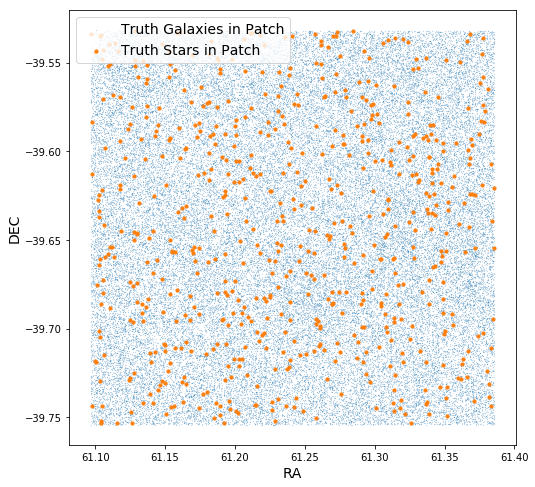

In [32]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.set_xlabel('RA', fontsize=14)
ax.set_ylabel('DEC', fontsize=14)

ax.scatter(truth_patch['ra'], truth_patch['dec'], s=0.01, label='Truth Galaxies in Patch')
ax.scatter(truth_patch[truth_patch['star']]['ra'], truth_patch[truth_patch['star']]['dec'], s=10, label='Truth Stars in Patch') 

ax.legend(prop={'size':14})

## plot some sources

In [33]:
ra = truth_patch['ra']
dec = truth_patch['dec']

a = truth_patch['a_true']
b = truth_patch['b_true']

a_no_psf = truth_patch['a_true_no_psf']
b_no_psf = truth_patch['b_true_no_psf']

theta = truth_patch['theta_true']

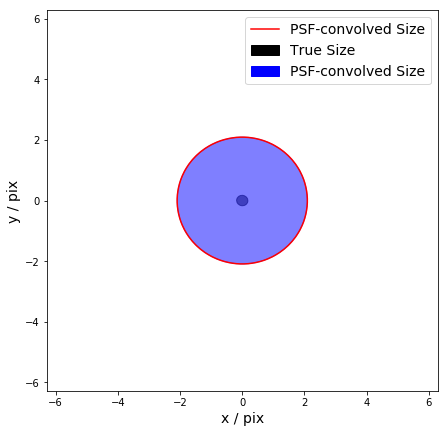

In [34]:
N = len(truth_patch)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

for i in np.random.randint(0, high=N, size=1):

    rough_size = 3*np.sqrt( a[i]*b[i] )
    
    params = ab2AB(a[i], b[i], theta[i], 0, 0)
    plot_shape( 0, 0, rough_size, params, c='r', ls='-', ax=ax)
    
    ellipse = Ellipse((0, 0), width = 2*a_no_psf[i], height = 2*b_no_psf[i],\
                      angle = theta[i], color='k', alpha=0.5, linewidth=1)

    ax.add_artist(ellipse)
    
    ellipse = Ellipse((0, 0), width = 2*a[i], height = 2*b[i], \
                      angle = theta[i], color='b', alpha=0.5, linewidth=1)

    ax.add_artist(ellipse)
    
    ax.set_xlabel('x / pix', fontsize=14)
    ax.set_ylabel('y / pix', fontsize=14)

    
    ax.fill_between([], [], [], color='k', label='True Size')
    ax.fill_between([], [], [], color='b', label='PSF-convolved Size')
    ax.plot([], [], color='r', label='PSF-convolved Size')

    ax.legend(prop={'size':14})
        

### Match the two catalogs with KD tree (primary  match, only by position and magnitude)

In [35]:
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u

In [36]:
coord1 = SkyCoord(obj['ra'], obj['dec'], unit=u.deg)
coord2 = SkyCoord(truth['ra'], truth['dec'], unit=u.deg)

## search in tree the closest to objects
## idx, d2d, d3d has the same length of the object catalog
idx, d2d, d3d = match_coordinates_sky(coord1, coord2)

In [37]:
truth_match = truth[idx]
truth_match['obj_id'] = obj['obj_id']

In [38]:
## number of repeated matches
print(len(truth_match['id']), '-', len(set(truth_match['id'])), '=', len(truth_match['id']) - len(set(truth_match['id'])) )

283447 - 280739 = 2708


In [39]:
## find distance cut
rad_mask = d2d.arcsec < 1.0

print('within radius / all closest:')
print(np.sum(rad_mask), '/', len(d2d), '=', np.sum(rad_mask)/len(d2d))

truth_match_dcut = truth_match[rad_mask]

#n, bins, patches = plt.hist(3600*d2d[rad_mask], bins='auto', label='within radius cut')
#plt.xlabel('distance between matched sources (arcsec)', fontsize=14)
#plt.show()

within radius / all closest:
278236 / 283447 = 0.9816156106785395


In [40]:
## number of repeated matches
print(len(truth_match_dcut['id']), '-', len(set(truth_match_dcut['id'])), 
      '=', len(truth_match_dcut['id']) - len(set(truth_match_dcut['id'])) )

278236 - 277765 = 471


In [41]:
## find magnitude cut
obj_dcut = obj[rad_mask]
mag_diff =  obj_dcut['mag_i_cModel'] - truth_match_dcut['mag_i']
mag_mask = np.abs(mag_diff) < 2
                                
print('within mag_diff / all mag_diff:')
print(np.sum(mag_mask), '/', len(truth_match_dcut), '=', np.sum(mag_mask)/len(truth_match_dcut))

truth_match_dcut_mcut = truth_match_dcut[mag_mask]
                                
#n, bins, patches = plt.hist(list(mag_diff), bins='auto')
#plt.xlabel('mag i difference between matching', fontsize=14)
#plt.show()

within mag_diff / all mag_diff:
268330 / 278236 = 0.9643971304935378


/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [42]:
## number of repeated matches
repeated_primary = len(truth_match_dcut_mcut['id']) - len(set(truth_match_dcut_mcut['id']))
print(len(truth_match_dcut_mcut['id']), '-', len(set(truth_match_dcut_mcut['id'])), 
      '=', repeated_primary)

268330 - 268148 = 182


In [43]:
truth_match_dcut_mcut.rename_column('ra', 'ra_true')
truth_match_dcut_mcut.rename_column('dec', 'dec_true')

In [44]:
match = join(obj, truth_match_dcut_mcut, keys='obj_id', join_type='left')

for col in truth_match_dcut_mcut.columns:
    match[col].fill_value = -1

match['PM_FLAG'] = True ## primary match flag
match['PM_FLAG'] *= (match['ra_true'].filled() > 0)


In [45]:
## calculate relative position of truth w.r.t. detection in pixel coordinates

match['dx'] = (match['ra_true'] - match['ra']) * np.cos(np.radians( (match['dec_true']+match['dec']) / 2 )) * 3600 / 0.2
match['dy'] = (match['dec_true'] - match['dec']) * 3600 / 0.2


In [46]:
match.write('primary_match_tract_3447.fits', format='fits', overwrite=True)

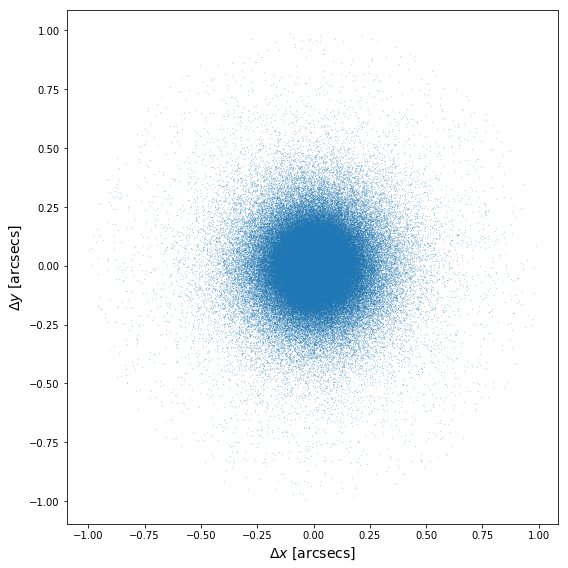

In [47]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.set_xlabel(r'$\Delta x$ [arcsecs]', fontsize=14)
ax.set_ylabel(r'$\Delta y$ [arcsecs]', fontsize=14)

ax.scatter(match['dx']*0.2, match['dy']*0.2, s=0.01)
plt.tight_layout()

## save the un-matched truth for the second round match

In [48]:
ids = Table({'id': list( set(truth['id']) - set(truth_match_dcut_mcut['id']))})                      
un_matched = join(truth, ids, keys='id', join_type='inner')

for c in list(un_matched.columns):
    un_matched.rename_column(c, c+'_bl')

un_matched.write('unmatched_tract_3447.fits', format='fits', overwrite=True)

In [49]:
print(len(un_matched), '+', len(truth_match_dcut_mcut), f'- {repeated_primary}', '=', len(truth))

695575 + 268330 - 182 = 963723


In [50]:
695575 + 268330 - 182

963723

## compare the shapes of a matched pair

In [51]:
pair = match[ match['PM_FLAG'] & (match['extendedness']==1) & (match['mag_i_cModel'] < 24.5)]
diff = pair['theta_true'] - pair['theta_obj']

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


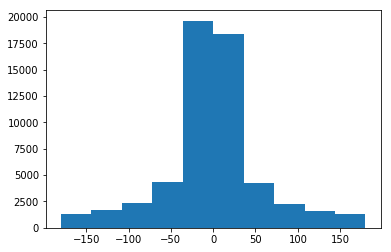

In [52]:
hist = plt.hist(diff)

In [53]:
a_det = pair['a_obj']
b_det = pair['b_obj']
theta_det = pair['theta_obj']

a_true = pair['a_true']
b_true = pair['b_true']
theta_true = pair['theta_true']

x0 = pair['x']
y0 = pair['y']

x0_true = pair['x'] + pair['dx']
y0_true = pair['y'] + pair['dy']
               
N = len(pair)

ra = pair['ra']
dec = pair['dec']

45302
position angle truth: 124.09540325575648
position angle detection: 121.74189088002547


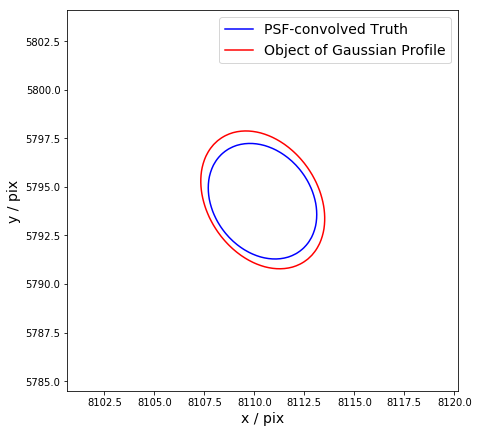

In [54]:
fig = plt.figure(figsize=(7,7))

for i in np.random.randint(0, high=N, size=1):
    
    print(i) 
    print('position angle truth:', pair['theta_true'][i])
    print('position angle detection:', pair['theta_obj'][i])

    
    ax = fig.add_subplot(111)
    
    radec = lsst.geom.SpherePoint(ra[i], dec[i], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)


    ######## pixels coordinates ##########
    
    rough_size = 3 * np.sqrt( a_det[i]*b_det[i] )
    
    #params_obj = [pair[f'{X}o'][i] for X in ['A', 'B', 'C', 'D', 'E', 'F'] ]
    #plot_shape( x0[i], y0[i], rough_size, params_obj, c='r', ls='--', ax=ax1)
    
    params_obj_fud = ab2AB(a_det[i], b_det[i], theta_det[i], x0[i], y0[i])
    plot_shape( x0[i], y0[i], rough_size, params_obj_fud, c='r', ls='-', ax=ax)
    
    params_truth = ab2AB(a_true[i], b_true[i], theta_true[i], x0_true[i], y0_true[i])
    plot_shape( x0_true[i], y0_true[i], rough_size, params_truth, c='b', ls='-', ax=ax)

    ax.set_xlabel('x / pix', fontsize=14)
    ax.set_ylabel('y / pix', fontsize=14)
    
 
    ax.plot([], [], 'b-', label='PSF-convolved Truth')
    #ax.plot([], [], 'r--', label='Object')
    ax.plot([], [], 'r-', label='Object of Gaussian Profile')
        
    ax.legend(prop={'size':14})

    #plt.savefig(f'primary/{i}.jpeg')
    #plt.cla()

## Overlay on images

In [55]:
pair = pair[ pair['patch'] == pat ]
N = len(pair)

a_det = pair['a_obj']
b_det = pair['b_obj']
theta_det = pair['theta_obj']

a_no_psf = pair['a_true_no_psf']
b_no_psf = pair['b_true_no_psf']

a_true = pair['a_true']
b_true = pair['b_true']
theta_true = pair['theta_true']

dx = pair['dx']
dy = pair['dy']
               
N = len(pair)

ra = pair['ra']
dec = pair['dec']

cutout_size = 20  # 300 pixels -> about 1 arcmin; use even-number size!!
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

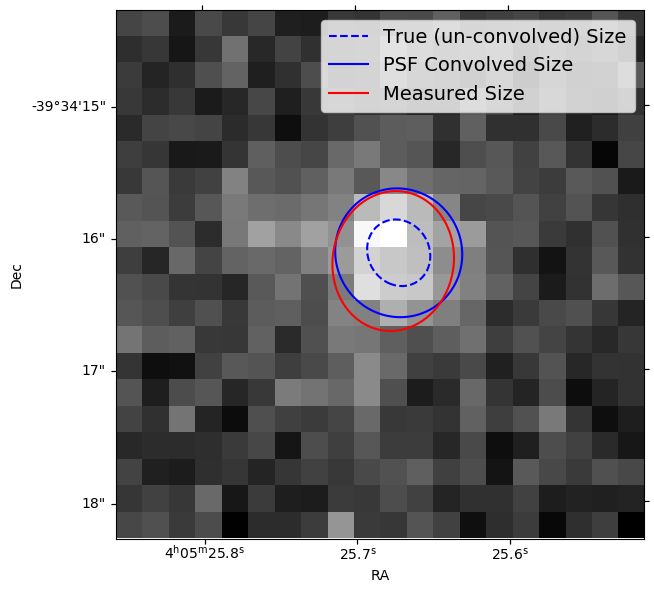

In [56]:

for i in np.random.randint(0, high=N, size=1):
#for i in [135, 558, 1294, 1476, 1845, 1858, 1875, 1881, 2008, 505]:
    
    radec = lsst.geom.SpherePoint(pair["ra"][i], pair["dec"][i], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    
    if np.floor(center.x) - np.round(center.x) == 0:
        pix_center_x = center.x
    else:
        pix_center_x = center.x + 1
        
    if np.floor(center.y) - np.round(center.y) == 0:
        pix_center_y = center.y
    else:
        pix_center_y = center.y + 1
        
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((pix_center_x - cutout_size*0.5, pix_center_y - cutout_size*0.5)), cutout_extent)

    cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)
    wcs = cutout.getWcs()

    off = lsst.geom.Extent2D(-(pix_center_x - cutout_size*0.5), -(pix_center_y - cutout_size*0.5))
    wcs_new = wcs.copyAtShiftedPixelOrigin(off)
    wcs_fits_meta = wcs_new.getFitsMetadata()
    
    image_arr = cutout.getMaskedImage().getImage().array
    
    fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(7, 7), dpi=100)

    #vmin, vmax = ZScaleInterval().get_limits(image_arr)
    vmin, vmax = image_arr.min(), image_arr.max()
    
    ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')
    
    rough_size = 3*np.sqrt( a_det[i]*b_det[i] )   
    
    params = ab2AB(a_no_psf[i], b_no_psf[i], theta_true[i], cutout_size/2 + dx[i], cutout_size/2 + dy[i])
    plot_shape( cutout_size/2, cutout_size/2, rough_size, params, c='b', ls='--', ax=ax)
    
    params = ab2AB(a_true[i], b_true[i], theta_true[i], cutout_size/2 + dx[i], cutout_size/2 + dy[i])
    plot_shape( cutout_size/2, cutout_size/2, rough_size, params, c='b', ls='-', ax=ax)
    
    params = ab2AB(a_det[i], b_det[i], theta_det[i], cutout_size/2, cutout_size/2)
    plot_shape( cutout_size/2, cutout_size/2, rough_size, params, c='r', ls='-', ax=ax)
        
    ax.plot([], [], 'b--', label='True (un-convolved) Size')
    ax.plot([], [], 'b-', label='PSF Convolved Size')
    ax.plot([], [], 'r-', label='Measured Size')
    
    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    
    ax.legend(prop={'size':14})
    
    #plt.savefig(f'./obj/{i}.jpeg')
    #plt.cla()

# second round match for un-recognized blends

In [57]:
match = Table.read('primary_match_tract_3447.fits', format='fits')
un_matched = Table.read('unmatched_tract_3447.fits', format='fits')

In [58]:
coord1 = SkyCoord(obj['ra'], obj['dec'], unit=u.deg)
coord2 = SkyCoord(un_matched['ra_bl'], un_matched['dec_bl'], unit=u.deg)

## search in tree the closest to objects
## idx, d2d has the same length of the object catalog
idx, d2d, d3d = match_coordinates_sky(coord1, coord2)

pbl = un_matched[idx]  ## potential blends
pbl['obj_id'] = obj['obj_id']

match = join(match, pbl, keys='obj_id', join_type='left')

for col in pbl.columns:
    match[col].fill_value = -1

In [59]:
## relative position of blends w.r.t. detection

match['dx_bl'] = (match['ra_bl'] - match['ra']) * np.cos(np.radians( (match['dec_bl']+match['dec']) / 2 )) * 3600 / 0.2
match['dy_bl'] = (match['dec_bl'] - match['dec']) * 3600 / 0.2

## match using KDtree (distance and magnitude cut)

In [60]:
match['BL_FLAG_kd'] = False

## find distance cut

rad_mask = d2d.arcsec < 1

## find magnitude cut
mag_diff =  match['mag_i_cModel'] - match['mag_i_bl'].filled()
mag_mask = np.abs(mag_diff) < 2

kd_mask =  match['PM_FLAG'] * rad_mask * mag_mask     ## if has a primary match, and has a secondary match within cuts

match['BL_FLAG_kd'][kd_mask] = True

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


## all the cuts on the objects are done here!

In [61]:
match = match[ match['clean'] & (match['mag_i_cModel'] < 24.5) & (match['extendedness']==1) ]

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


## match using Ellipse Matching (and magnitude cut)

In [62]:
%%capture --no-stdout

match['BL_FLAG'] = False

N = len(match)
for i in range(N):
    if i%10000==0:
        print(i, '/', N)
    p1 = ab2AB(match['a_obj'][i], match['b_obj'][i], match['theta_obj'][i], match['x'][i], match['y'][i])
    p2 = ab2AB(match['a_true_bl'][i], match['b_true_bl'][i], match['theta_true_bl'][i], 
               match['x'][i] + match['dx_bl'][i], match['y'][i] + match['dy_bl'][i])
    if is_overlapping(p1, p2):
        match['BL_FLAG'][i] = True


0 / 59284
10000 / 59284
20000 / 59284
30000 / 59284
40000 / 59284
50000 / 59284


In [63]:
mag_diff =  match['mag_i_cModel'] - match['mag_i_bl'].filled()
mag_mask = np.abs(mag_diff) < 2

match['BL_FLAG'] = match['BL_FLAG'] * match['PM_FLAG'] * mag_mask ## if has a primary match, and has a secondary match within cuts

In [64]:
blends = match[ match['BL_FLAG'] ]
pure = match[ (~match['BL_FLAG']) & match['PM_FLAG']]

blends_kd = match[ match['BL_FLAG_kd'] ]
pure_kd = match[( ~match['BL_FLAG_kd'])  & match['PM_FLAG'] ]

In [95]:
blends_patch = blends[ blends['patch'] == pat ]

N = len(blends_patch)

a_det = blends_patch['a_obj']
b_det = blends_patch['b_obj']
theta_det = blends_patch['theta_obj']

a_true = blends_patch['a_true']
b_true = blends_patch['b_true']
theta_true = blends_patch['theta_true']

a_bl = blends_patch['a_true_bl']
b_bl = blends_patch['b_true_bl']
theta_bl = blends_patch['theta_true_bl']

cutout_size = 26  # 300 pixels -> about 1 arcmin; use even-number size!!
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

dx_pm, dy_pm = blends_patch['dx'], blends_patch['dy']
dx_bl, dy_bl = blends_patch['dx_bl'], blends_patch['dy_bl']

80


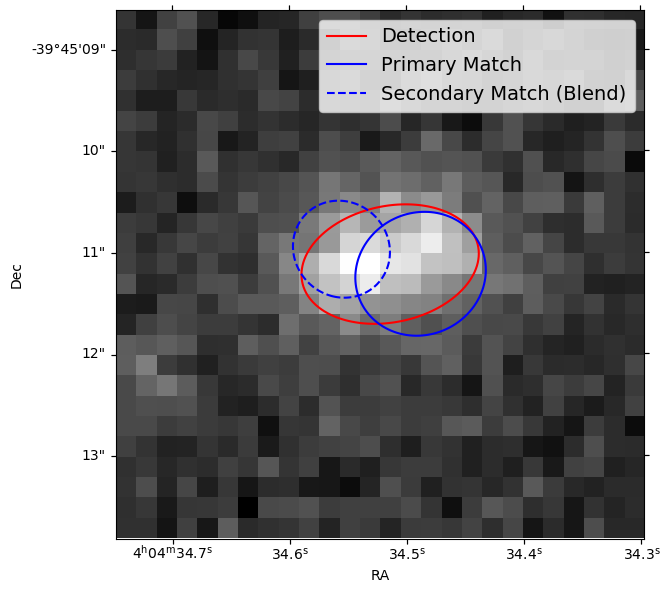

In [105]:
for i in np.random.randint(0, high=N, size=1):
    
    print(i)
    radec = lsst.geom.SpherePoint(blends_patch["ra"][i], blends_patch["dec"][i], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    
    if np.floor(center.x) - np.round(center.x) == 0:
        pix_center_x = center.x
    else:
        pix_center_x = center.x + 1
        
    if np.floor(center.y) - np.round(center.y) == 0:
        pix_center_y = center.y
    else:
        pix_center_y = center.y + 1
        
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((pix_center_x - cutout_size*0.5, pix_center_y - cutout_size*0.5)), cutout_extent)
    
    
    cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)
    wcs = cutout.getWcs()

    off = lsst.geom.Extent2D(-(center.x - cutout_size*0.5), -(center.y - cutout_size*0.5))
    wcs_new = wcs.copyAtShiftedPixelOrigin(off)
    wcs_fits_meta = wcs_new.getFitsMetadata()
    
    image_arr = cutout.getMaskedImage().getImage().array
    
    fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(7, 7), dpi=100)

    #vmin, vmax = ZScaleInterval().get_limits(image_arr)
    vmin, vmax = image_arr.min(), image_arr.max()
    
    ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')

       
    params = ab2AB(a_det[i], b_det[i], theta_det[i], cutout_size/2, cutout_size/2)
    plot_shape(cutout_size/2, cutout_size/2, rough_size, params, c='r', ls='-', ax=ax)
    
    params = ab2AB(a_true[i], b_true[i], theta_true[i], cutout_size/2 + dx_pm[i], cutout_size/2 + dy_pm[i])
    plot_shape(cutout_size/2 + dx_pm[i], cutout_size/2 + dy_pm[i], rough_size, params, c='b', ls='-', ax=ax)
    
    params = ab2AB(a_bl[i], b_bl[i], theta_bl[i], cutout_size/2 + dx_bl[i], cutout_size/2 + dy_bl[i])
    plot_shape(cutout_size/2 + dx_bl[i], cutout_size/2 + dy_bl[i], rough_size, params, c='b', ls='--', ax=ax)

 
    ax.plot([], [], 'r-', label='Detection')
    ax.plot([], [], 'b-', label='Primary Match')
    ax.plot([], [], 'b--', label='Secondary Match (Blend)')

    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    
    ax.legend(prop={'size':14})
    
    #plt.savefig(f'blends/{i}.jpeg')
    #plt.cla()

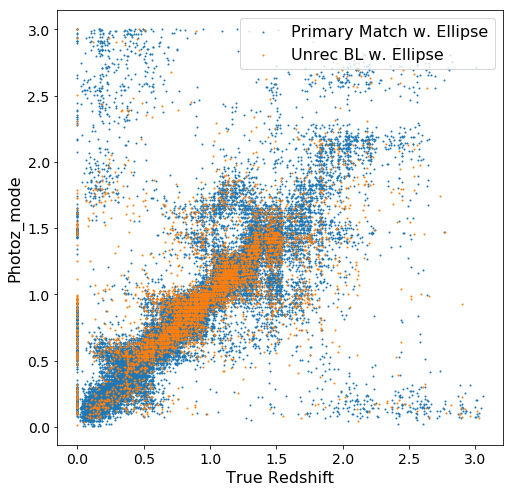

In [106]:
plt.figure(figsize=(8, 8))
plt.scatter(pure['redshift'], pure['photoz_mode'], s=1, label='Primary Match w. Ellipse')
plt.scatter(blends['redshift'], blends['photoz_mode'], s=1, label='Unrec BL w. Ellipse')

plt.xlabel('True Redshift', fontsize=16)
plt.ylabel('Photoz_mode', fontsize=16)
plt.axis('equal')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size':16})
#plt.savefig('zzf.png')

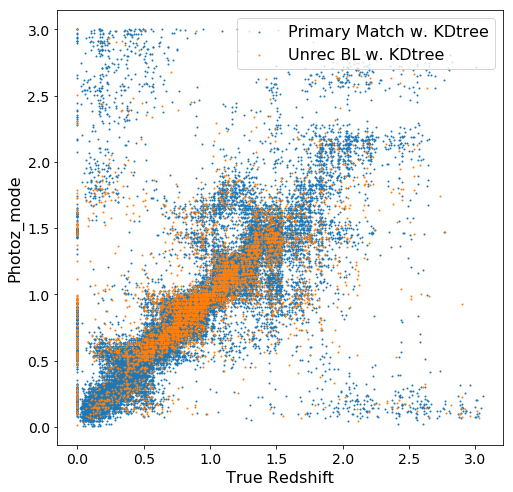

In [107]:
plt.figure(figsize=(8, 8))
plt.scatter(pure_kd['redshift'], pure_kd['photoz_mode'], s=1, label='Primary Match w. KDtree')
plt.scatter(blends_kd['redshift'], blends_kd['photoz_mode'], s=1, label='Unrec BL w. KDtree')

plt.xlabel('True Redshift', fontsize=16)
plt.ylabel('Photoz_mode', fontsize=16)
plt.axis('equal')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size':16})
#plt.savefig('zzf.png')

In [108]:
hist_kd = np.abs(blends_kd['photoz_mode'] - blends_kd['redshift']) / (1 + blends_kd['redshift'])
hist_ell = np.abs(blends['photoz_mode'] - blends['redshift']) / (1 + blends['redshift'])

## distance-only vs. shape matching, some numbers

In [109]:
print('number of unrecognized blends:')
print(len(hist_kd), len(hist_ell))

print('photo-z outlier of unrecognized blends:')
print(np.sum(hist_kd>0.15), np.sum(hist_ell>0.15))

print('outlier fraction:')
print(np.sum(hist_kd>0.15)/len(hist_kd), np.sum(hist_ell>0.15)/len(hist_ell))

number of unrecognized blends:
4762 5021
photo-z outlier of unrecognized blends:
1061 1104
outlier fraction:
0.22280554388912222 0.21987651862178847


In [110]:
hist_kd = np.abs(pure_kd['photoz_mode'] - pure_kd['redshift']) / (1 + pure_kd['redshift'])
hist_ell = np.abs(pure['photoz_mode'] - pure['redshift']) / (1 + pure['redshift'])

In [111]:
print('number of pure sources')
print(len(hist_kd), len(hist_ell))

print('photo-z outlier of pure sources:')
print(np.sum(hist_kd>0.15), np.sum(hist_ell>0.15))

print('outlier fraction:')
print(np.sum(hist_kd>0.15)/len(hist_kd), np.sum(hist_ell>0.15)/len(hist_ell))

number of pure sources
52458 52199
photo-z outlier of pure sources:
4853 4810
outlier fraction:
0.09251210492203286 0.0921473591448112


## in the KD-bl sample, not in ellipse-bl sample

In [114]:
ids = Table({'obj_id': list( set(blends_kd['obj_id']) - set(blends['obj_id']))})                      
extra_bl = join(blends_kd, ids, keys='obj_id', join_type='inner')

hist_extra_bl = np.abs(extra_bl['photoz_mode'] - extra_bl['redshift']) / (1 + extra_bl['redshift'])

print('number of exclusive sample:', len(extra_bl))
print('number of exclusive photoz outliers:', np.sum(hist_extra_bl>0.15))
print('outlier fraction of exclusive sample:', np.sum(hist_extra_bl>0.15)/len(extra_bl))

number of exclusive sample: 67
number of exclusive photoz outliers: 11
outlier fraction of exclusive sample: 0.16417910447761194


In [115]:
blends_patch = extra_bl[ extra_bl['patch'] == pat ]

N = len(blends_patch)

a_det = blends_patch['a_obj']
b_det = blends_patch['b_obj']
theta_det = blends_patch['theta_obj']

a_true = blends_patch['a_true']
b_true = blends_patch['b_true']
theta_true = blends_patch['theta_true']

a_bl = blends_patch['a_true_bl']
b_bl = blends_patch['b_true_bl']
theta_bl = blends_patch['theta_true_bl']

dx_pm, dy_pm = blends_patch['dx'], blends_patch['dy']
dx_bl, dy_bl = blends_patch['dx_bl'], blends_patch['dy_bl']


cutout_size = 26  # 300 pixels -> about 1 arcmin; use even-number size!!
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

index: 2
distance to secondary match: 0.9193425303436209


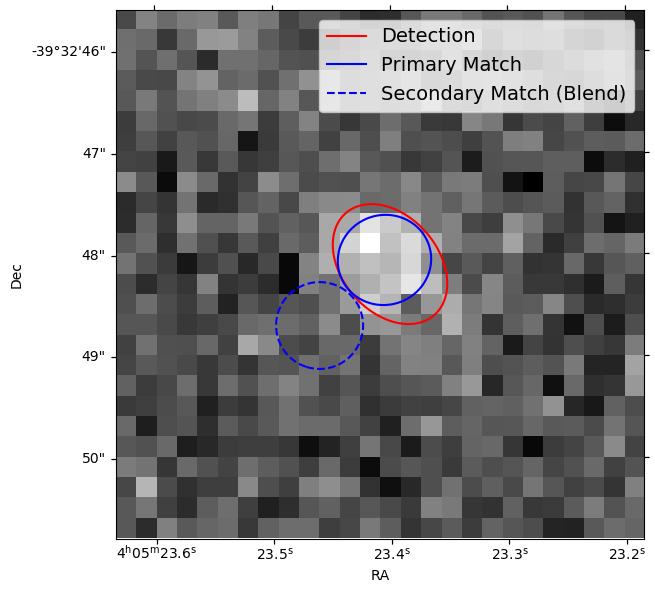

In [118]:

for i in np.random.randint(0, high=N, size=1):
    
    dist2 = ( (blends_patch["ra"][i] - blends_patch["ra_bl"][i]) * np.cos(np.radians(blends_patch['dec'][i] )) )**2 + (blends_patch["dec"][i] - blends_patch["dec_bl"][i])**2 
    dist = np.sqrt(dist2 * 3600**2)
    print("index:", i)
    print( "distance to secondary match:", dist)
    radec = lsst.geom.SpherePoint(blends_patch["ra"][i], blends_patch["dec"][i], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    
    if np.floor(center.x) - np.round(center.x) == 0:
        pix_center_x = center.x
    else:
        pix_center_x = center.x + 1
        
    if np.floor(center.y) - np.round(center.y) == 0:
        pix_center_y = center.y
    else:
        pix_center_y = center.y + 1
        
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((pix_center_x - cutout_size*0.5, pix_center_y - cutout_size*0.5)), cutout_extent)
    
    
    cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)
    wcs = cutout.getWcs()

    off = lsst.geom.Extent2D(-(center.x - cutout_size*0.5), -(center.y - cutout_size*0.5))
    wcs_new = wcs.copyAtShiftedPixelOrigin(off)
    wcs_fits_meta = wcs_new.getFitsMetadata()
    
    image_arr = cutout.getMaskedImage().getImage().array
    
    fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(7, 7), dpi=100)

    #vmin, vmax = ZScaleInterval().get_limits(image_arr)
    vmin, vmax = image_arr.min(), image_arr.max()
    
    ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')

       
    params = ab2AB(a_det[i], b_det[i], theta_det[i], cutout_size/2, cutout_size/2)
    plot_shape(cutout_size/2, cutout_size/2, rough_size, params, c='r', ls='-', ax=ax)
    
    params = ab2AB(a_true[i], b_true[i], theta_true[i], cutout_size/2 + dx_pm[i], cutout_size/2 + dy_pm[i])
    plot_shape(cutout_size/2 + dx_pm[i], cutout_size/2 + dy_pm[i], rough_size, params, c='b', ls='-', ax=ax)
    
    params = ab2AB(a_bl[i], b_bl[i], theta_bl[i], cutout_size/2 + dx_bl[i], cutout_size/2 + dy_bl[i])
    plot_shape(cutout_size/2 + dx_bl[i], cutout_size/2 + dy_bl[i], rough_size, params, c='b', ls='--', ax=ax)

 
    ax.plot([], [], 'r-', label='Detection')
    ax.plot([], [], 'b-', label='Primary Match')
    ax.plot([], [], 'b--', label='Secondary Match (Blend)')

    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    
    ax.legend(prop={'size':14})
    
    #plt.savefig(f'blends/{i}.jpeg')
    #plt.cla()

## in the ellipse-bl sample, not in KD-bl sample

In [119]:
ids = Table({'obj_id': list( set(blends['obj_id']) - set(blends_kd['obj_id']))})                      
extra_bl = join(blends, ids, keys='obj_id', join_type='inner')

hist_extra_bl = np.abs(extra_bl['photoz_mode'] - extra_bl['redshift']) / (1 + extra_bl['redshift'])

print('number of exclusive sample:', len(extra_bl))
print('number of exclusive photoz outliers:', np.sum(hist_extra_bl>0.15))
print('outlier fraction of exclusive sample:', np.sum(hist_extra_bl>0.15)/len(extra_bl))

number of exclusive sample: 326
number of exclusive photoz outliers: 54
outlier fraction of exclusive sample: 0.1656441717791411


In [120]:
blends_patch = extra_bl[ extra_bl['patch'] == pat ]

N = len(blends_patch)

a_det = blends_patch['a_obj']
b_det = blends_patch['b_obj']
theta_det = blends_patch['theta_obj']

a_true = blends_patch['a_true']
b_true = blends_patch['b_true']
theta_true = blends_patch['theta_true']

a_bl = blends_patch['a_true_bl']
b_bl = blends_patch['b_true_bl']
theta_bl = blends_patch['theta_true_bl']

dx_pm, dy_pm = blends_patch['dx'], blends_patch['dy']
dx_bl, dy_bl = blends_patch['dx_bl'], blends_patch['dy_bl']


cutout_size = 26  # 300 pixels -> about 1 arcmin; use even-number size!!
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

index: 12
distance to secondary match: 1.2800836272155354


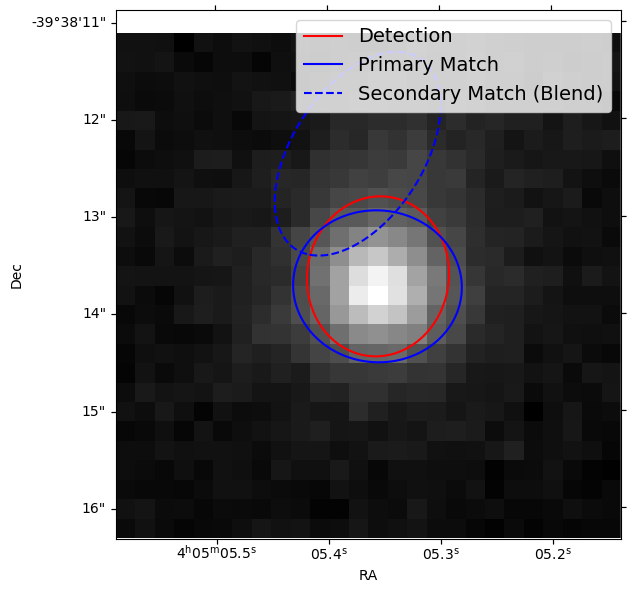

In [123]:

for i in np.random.randint(0, high=N, size=1):
    
    dist2 = ( (blends_patch["ra"][i] - blends_patch["ra_bl"][i]) * np.cos(np.radians(blends_patch['dec'][i] )) )**2 + (blends_patch["dec"][i] - blends_patch["dec_bl"][i])**2 
    dist = np.sqrt(dist2 * 3600**2)
    print("index:", i)
    print( "distance to secondary match:", dist)
    radec = lsst.geom.SpherePoint(blends_patch["ra"][i], blends_patch["dec"][i], lsst.geom.degrees)
    center = skymap.findTract(radec).getWcs().skyToPixel(radec)
    
    if np.floor(center.x) - np.round(center.x) == 0:
        pix_center_x = center.x
    else:
        pix_center_x = center.x + 1
        
    if np.floor(center.y) - np.round(center.y) == 0:
        pix_center_y = center.y
    else:
        pix_center_y = center.y + 1
        
    bbox = lsst.geom.BoxI(lsst.geom.Point2I((pix_center_x - cutout_size*0.5, pix_center_y - cutout_size*0.5)), cutout_extent)
    
    
    cutout = butler.get("deepCoadd_sub", dataId=dataId, bbox=bbox)
    wcs = cutout.getWcs()

    off = lsst.geom.Extent2D(-(center.x - cutout_size*0.5), -(center.y - cutout_size*0.5))
    wcs_new = wcs.copyAtShiftedPixelOrigin(off)
    wcs_fits_meta = wcs_new.getFitsMetadata()
    
    image_arr = cutout.getMaskedImage().getImage().array
    
    fig, ax = plt.subplots(subplot_kw={'projection': WCS(wcs_fits_meta)}, figsize=(7, 7), dpi=100)

    #vmin, vmax = ZScaleInterval().get_limits(image_arr)
    vmin, vmax = image_arr.min(), image_arr.max()
    
    ax.imshow(image_arr, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')

       
    params = ab2AB(a_det[i], b_det[i], theta_det[i], cutout_size/2, cutout_size/2)
    plot_shape(cutout_size/2, cutout_size/2, rough_size, params, c='r', ls='-', ax=ax)
    
    params = ab2AB(a_true[i], b_true[i], theta_true[i], cutout_size/2 + dx_pm[i], cutout_size/2 + dy_pm[i])
    plot_shape(cutout_size/2 + dx_pm[i], cutout_size/2 + dy_pm[i], rough_size, params, c='b', ls='-', ax=ax)
    
    params = ab2AB(a_bl[i], b_bl[i], theta_bl[i], cutout_size/2 + dx_bl[i], cutout_size/2 + dy_bl[i])
    plot_shape(cutout_size/2 + dx_bl[i], cutout_size/2 + dy_bl[i], rough_size, params, c='b', ls='--', ax=ax)

 
    ax.plot([], [], 'r-', label='Detection')
    ax.plot([], [], 'b-', label='Primary Match')
    ax.plot([], [], 'b--', label='Secondary Match (Blend)')

    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    
    ax.legend(prop={'size':14})
    
    #plt.savefig(f'blends/{i}.jpeg')
    #plt.cla()